In [1]:
from ocean_navigation_simulator.utils.misc import get_c3
import os
%load_ext autoreload
%autoreload 2

In [2]:
c3 = get_c3()

Starting to connect to c3


In [102]:
experiment_name = "multi_agent_dev"
exp = c3.Experiment.get(experiment_name)
exp
#exp.remove()

c3.Experiment(
 id='multi_agent_dev',
 meta=c3.Meta(
        tenantTagId=32,
        tenant='seaweed-control',
        tag='devseaweedrc1',
        created=datetime.datetime(2023, 2, 1, 1, 28, 5, tzinfo=datetime.timezone.utc),
        createdBy='mariuswiggert@berkeley.edu',
        updated=datetime.datetime(2023, 2, 1, 1, 28, 5, tzinfo=datetime.timezone.utc),
        updatedBy='mariuswiggert@berkeley.edu',
        timestamp=datetime.datetime(2023, 2, 1, 1, 28, 5, tzinfo=datetime.timezone.utc),
        fetchInclude='[]',
        fetchType='Experiment'),
 version=1,
 experimentName='multi_agent_dev',
 description='multi agent test',
 arenaConfig={'casadi_cache_dict': {'deg_around_x_t': 2.0,
                                     'time_around_x_t': 432000},
               'multi_agent_constraints': {'collision_thrsld': 0.2,
                                           'communication_thrsld': 9,
                                           'epsilon_margin': 1,
                                   

# Set up the experiments

In [6]:
timeout_h = 24*5

In [7]:
arena_config = {
    "casadi_cache_dict": {"deg_around_x_t": 2.0, "time_around_x_t": 432000},
    "timeout": timeout_h * 3600,
    "platform_dict": {
        "battery_cap_in_wh": 400.0,
        "u_max_in_mps": 0.1,
        "motor_efficiency": 1.0,
        "solar_panel_size": 0.5,
        "solar_efficiency": 0.2,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "data/miss_gen_hindcast/",
                "local": False,
                "source": "HYCOM",
                "type": "hindcast",
                "currents": "total",
                #  "region": "Region 1"
            },
        },
        "forecast": None,#{
        #     "field": "OceanCurrents",
        #     "source": "forecast_files",
        #     "source_settings": {
        #         "folder": "data/miss_gen_forecast/",
        #         "local": False,
        #         "source": "Copernicus",
        #         "type": "forecast",
        #         "currents": "total",
        #         # "region": "Region 1",
        #     },
        #},
    },
    "multi_agent_constraints": {
        "unit": "km",
        "communication_thrsld": 9,
        "epsilon_margin": 1,  # when add edges based on hysteresis
        "collision_thrsld": 0.2,
    },
}
objectiveConfig = {'type': "nav"}


feasibilityCheckSettings = c3.FeasibilityCheckSettings(**{
    'deg_around_xt_xT_box': 1.,
    'grid_res': 0.02})

In [8]:
# create Experiment
exp = c3.Experiment.createNew(
    name = experiment_name,
    description = "multi agent test",
    arenaConfig = arena_config,
    objectiveConfig= objectiveConfig,
    timeout_in_sec=3600*timeout_h, #72h
    feasibilityCheckSettings=feasibilityCheckSettings
)

# Set up generate batch job

## Set up and run mission generation

In [9]:
import datetime
missGenBatchConfig = {
    ##### Target Sampling #####
    # HYCOM HC: lon [-98.0,-76.4000244140625], lat[18.1200008392334,31.92000007629394]
    # Copernicus FC: lon: [-98.0, -76.416664], lat: [18.083334, 30.0]
    # Combined: [-98.0, -76.416664], [18.1200008392334, 30.0]
    "x_range": [-96, -78],
    "y_range": [20, 29],
    "t_range": [
        # Copernicus FC: 2022-04 until today, HYCOM Hindcast: 2021-09 until today
        datetime.datetime(year=2022, month=4, day=1, tzinfo=datetime.timezone.utc),
        datetime.datetime(year=2022, month=10, day=1, tzinfo=datetime.timezone.utc),
    ],
    "problem_timeout_in_h": 24*6, #to be considered as feasible
    "target_distance_from_land": 0.4,
    "problem_target_radius": 0.1,
    ##### HJ Planner #####
    "hj_specific_settings": {
        # 'grid_res' has to be smaller than target_radius to prevent hj_solver errors
        "grid_res": 0.02,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "direction": "multi-time-reach-back",
        "n_time_vector": 199,  # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "run_without_x_T": True,
        "progress_bar": False,
        "T_goal_in_seconds": 3600 * 24 * 6, # Jerome has 6 days here
    },
    "hj_planner_box": 2.0,
    ##### Start Sampling #####
    "feasible_missions_per_target": 3,
    "random_missions_per_target": 0,
    "multi_agent": {
        "is_multi_agent": True,
        "nb_platforms": 4,
        "sampling_range_radius_km": 20,
        "sample_range_ttr_h": [70, 110], # this has to be a larger than the "feasible_mission_time_in_h"
        # as the multi-agent points are sampled from "feasible_mission_time_in_h" with added noise which might 
        # increase their ttr by quite a lot (so either this interval has to be increased or the other reduced)
    },
    "min_distance_from_hj_frame": 0.,
    "min_distance_from_land": 0.5,
    "feasible_mission_time_in_h": [80, 90],
    "random_min_distance_from_target": 0.5,
    ##### Actions #####
    "plot_batch": False,
    "animate_batch": False,
    "cache_forecast": False,
    "cache_hindcast": False,
}

In [10]:
options = c3.GenMissionBatchJobOptionsNicolas(**{
    'experiment':exp,
    'missGenBatchConfig': missGenBatchConfig,
    'base_seed': 113,
    'nBatches': 2,
    'nMissionGenPerBatch': 3,
})

In [11]:
gen_mission_job = c3.GenMissionBatchJobNicolas(**{'options': options.toJson()}).upsert()
#gen_mission_job = c3.GenMissionBatchJob(**{'options': options.toJson()}).upsert()
# gen_mission_job.setMaxConcurrency(12)
# gen_mission_job.setMaxConcurrencyPerNode(15)
gen_mission_job.start()
gen_mission_job

c3.GenMissionBatchJobNicolas(
 typeIdent='BATCHJ:O_NIC_GENMISS_BATCH_JOB',
 id='8d6b9e8d-0618-4b97-a3f8-0aeee206126d',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 1, 1, 29, 53, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 1, 1, 29, 53, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 1, 1, 29, 53, tzinfo=datetime.timezone.utc)),
 version=1)

In [97]:
#gen_mission_job = c3.GenMissionBatchJobNicolas.get('8d6b9e8d-0618-4b97-a3f8-0aeee206126d')

gen_mission_job.status()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 2, 1, 1, 29, 54, tzinfo=datetime.timezone.utc),
 startedby='mariuswiggert@berkeley.edu',
 completed=datetime.datetime(2023, 2, 1, 1, 43, 22, tzinfo=datetime.timezone.utc),
 status='completed',
 newBatchSubmitted=False)

In [98]:
gen_mission_job.computingActions()
# gen_mission_job.cancel()

c3.JobComputingActionsResult()

In [103]:
len(exp.get('expMissions').expMissions)

12

In [27]:
#Other Utils for the cluster
c3.Cluster.actionDump()

c3.Arry<ClusterAction>([c3.ClusterAction(
  id='6530.2697302',
  target='c3/c3/BatchQueue?action=dispatchCompute',
  tenant='c3',
  tag='c3',
  status='Running',
  threadId='142',
  threadGroup='main',
  threadName='Hannibal-6',
  age='00:20:09.637',
  elapsed=1209637,
  secondaryKey='3b8b54dc-c428-4c64-8a34-5965ece52fb2',
  children=c3.Arry<Action>([c3.Action(
              id='6530.2698513',
              parentId='6530.2697302',
              target='seaweed-control/devseaweedrc1/BatchQueue?action=compute',
              tenant='seaweed-control',
              tag='devseaweedrc1',
              status='Running',
              age='00:20:04.198',
              elapsed=1204198,
              children=c3.Arry<Action>([c3.Action(
                          id='6530.2700466',
                          parentId='6530.2698513',
                          target='seaweed-control/devseaweedrc1/OceanSimRunBatchJob?action=dispatchProcessBatch',
                          tenant='seaweed-control',

Plot all of them on a map and get distribution information

In [104]:
exp.get('expMissions').expMissions[0].get('missionConfig').missionConfig

{'x_0': [{'lon': -79.58802795410156,
   'lat': 27.246288299560547,
   'date_time': '2022-09-09T12:17:49+00:00'},
  {'lon': -79.57960510253906,
   'lat': 27.242517471313477,
   'date_time': '2022-09-09T12:17:49+00:00'},
  {'lon': -79.58111572265625,
   'lat': 27.25318717956543,
   'date_time': '2022-09-09T12:17:49+00:00'},
  {'lon': -79.5793685913086,
   'lat': 27.246204376220703,
   'date_time': '2022-09-09T12:17:49+00:00'}],
 'x_T': {'lon': -79.5384030710877, 'lat': 27.108909706672566},
 'target_radius': 0.1,
 'seed': 30555,
 'feasible': True,
 'ttr_in_h': 101.52528568756271}

In [66]:
from ocean_navigation_simulator.reinforcement_learning.missions.CachedNavigationProblem import (
    CachedNavigationProblem,
)
from ocean_navigation_simulator.environment.PlatformState import (
    PlatformState,
    PlatformStateSet,
    SpatialPoint,
)

from ocean_navigation_simulator.utils import units

problems = []
for miss in exp.get('expMissions').expMissions:
    missionConfig = miss.get("missionConfig").missionConfig
    problems.append(CachedNavigationProblem.from_c3_mission_config(missionConfig))

In [47]:
problems[0]

Problem [start: [[-79.58803° -79.57961° -79.58112° -79.57937°],                       [27.24629° 27.24252° 27.25319° 27.24620°]],                       ['2022-09-09 12:17:49' '2022-09-09 12:17:49' '2022-09-09 12:17:49'
 '2022-09-09 12:17:49']], end: [-79.538403°,27.10891°], target_radius: 0.10, ttr: 102h] (INone, GNone BNone FINone)

In [48]:
import pandas as pd
from ocean_navigation_simulator.reinforcement_learning.runners.GenerationRunner import (
    GenerationRunner)

results_folder = f"{os.getcwd()}/"
df = pd.DataFrame([problem.to_dict() for problem in problems])
df['factory_index'] = 0
df.to_csv(results_folder + "problems.csv")

0     27.108910
1     27.108910
2     25.424360
3     25.424360
4     24.629775
5     24.629775
6     24.629775
7     20.722562
8     22.311709
9     22.233801
10    22.233801
11    22.233801
Name: x_T_lat, dtype: float64

/tmp/ipykernel_12959/3117225428.py:21: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



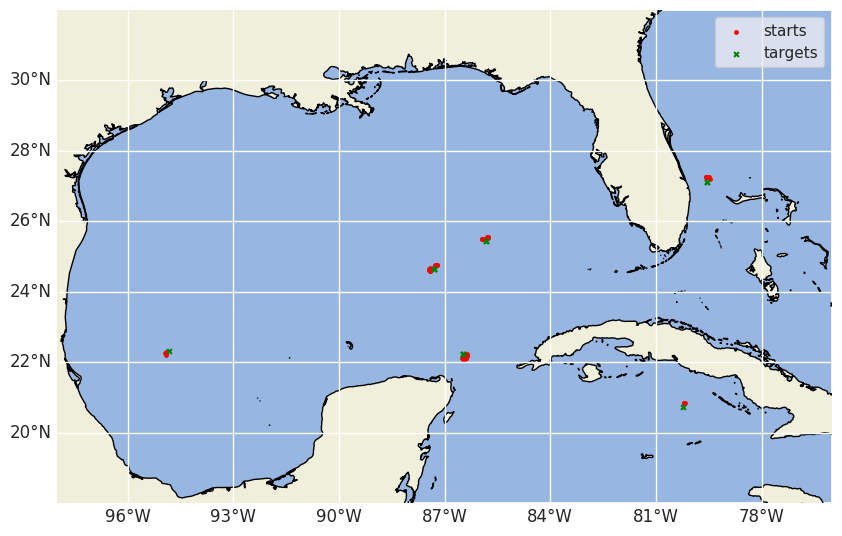

In [63]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_title("Time: " + datetime.fromtimestamp(time, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC'))
 
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')
ax.add_feature(cfeature.OCEAN, zorder=0)
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.axis(xmin=-98,xmax=-76)
ax.axis(ymin=18,ymax=32)
for miss_idx in range(len(df)):
    ax.scatter(df.iloc[miss_idx]["x_0_lon"], df.iloc[miss_idx]["x_0_lat"], c="red", marker="o", s=6, label="starts" if miss_idx==0 else None)
ax.scatter(df["x_T_lon"], df["x_T_lat"], c="green", marker="x", s=12, label="targets")
ax.legend()
# ax.get_figure().savefig(f"{analysis_folder}starts_and_targets.png")
ax.get_figure().show()

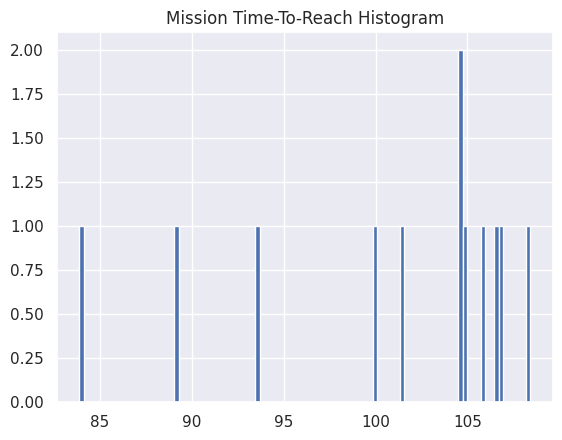

KeyError: 'multi_agent'

In [68]:
GenerationRunner.plot_ttr_histogram(results_folder)
GenerationRunner.plot_starts_and_targets(
    results_folder=results_folder, pb_filename="problems.csv", scenario_config=arena_config,
)

# Add Observer

In [69]:
# Config for No observer
observer_config = {"observer": None}
# add observer
exp.addObserver(name="NoObserver", observerConfig=observer_config)

c3.ObserverSetting(
 id='multi_agent_dev_NoObserver',
 name='NoObserver',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 1, 3, 7, 39, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 1, 3, 7, 39, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 1, 3, 7, 39, tzinfo=datetime.timezone.utc)),
 version=1)

# Add Controller

In [108]:
# Controller Configs
HJMultiTimeConfig = {
    "replan_every_X_seconds": None,
    "replan_on_new_fmrc": True,
    "T_goal_in_seconds": 3600 * 24 * 3,  # 3d, 43200,     # 12h
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner",
    "d_max": 0.0,
    "deg_around_xt_xT_box": 1.0,
    "direction": "multi-time-reach-back",
    "grid_res": 0.02,
    "n_time_vector": 200,
    "progress_bar": True,
    "use_geographic_coordinate_system": True,
}
StraightLineConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.NaiveController.NaiveController"
}
flockingConfig = {
    "unit": "km",
    "interaction_range": 9,  # km
    "grad_clip_range": 0.1,  # km
}
reactiveConfig = {
    "unit": "m",
    "mix_ttr_and_euclidean": False,
    "delta_3": 8800,  # collision threshold (communication - delta_3)
    "delta_2": 2000,  # safe zone threshold  ]communication - delta_2, communication - delta_3[
    "delta_1": 500,  # small threshold so that if distance > communication_thrsld- delta_1 we try to achieve connectivity
    "communication_thrsld": 9000,
    "k_1": 0.25,
    "k_2": 1,
}

MultiAgentCtrlConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.MultiAgentPlanner.MultiAgentPlanner",
    "high_level_ctrl": "flocking",  # choose from hj_naive, flocking, reactive_control
    "unit": "km",
    "communication_thrsld": 9,
    "hj_specific_settings": HJMultiTimeConfig,
    "flocking_config": flockingConfig,
    "reactive_control_config": reactiveConfig,
}

In [78]:
'id==' + "'" + experiment_name + "_" + "hj_naive" + "'"

"id=='multi_agent_dev_hj_naive'"

In [96]:
exp.get('experimentName')

c3.Experiment(
 id='multi_agent_dev',
 meta=c3.Meta(
        fetchInclude='[experimentName,id,version]',
        fetchType='Experiment'),
 version=1,
 experimentName='multi_agent_dev',
 T_horizon_FC_Error_Calculation_in_h=96)

In [88]:
exp.experimentName = exp.get('experiment_name')

In [110]:
# add controller
exp.addController(name='flocking_new', ctrlConfig=MultiAgentCtrlConfig)

c3.ControllerSetting(
 id='multi_agent_dev_flocking_new',
 name='flocking_new',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 1, 3, 50, 9, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 1, 3, 50, 9, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 1, 3, 50, 9, tzinfo=datetime.timezone.utc)),
 version=1)

# Create Ocean Sim Runs

In [106]:
# Create the Run objects
exp.createOceanSimRuns(ctrl_name='flocking', obs_name='NoObserver')

True

# Run Simulation

In [91]:
# Create the Experiment Batch Job Options
options = c3.OceanSimRunBatchJobOptions(**{
    'experiment': exp,
    'actionRuntime': 'nicolas' # enum('marius', 'andreas', 'matthias', 'nicolas')
})

In [92]:
# Start the Batch Job
run_job = c3.OceanSimRunBatchJob(**{'options': options.toJson()}).upsert()
# run_job.numAutoRecoveryAttempts = 1
run_job.start()
run_job

c3.OceanSimRunBatchJob(
 typeIdent='BATCHJ:O_OSRun',
 id='03b44bae-1a6e-4fa1-b07e-d906b48b84bf',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 1, 3, 31, 34, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 1, 3, 31, 34, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 1, 3, 31, 34, tzinfo=datetime.timezone.utc)),
 version=1)

In [99]:
#run_job = c3.OceanSimRunBatchJob.get('03b44bae-1a6e-4fa1-b07e-d906b48b84bf')
run_job.status()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 2, 1, 3, 31, 34, tzinfo=datetime.timezone.utc),
 startedby='mariuswiggert@berkeley.edu',
 completed=datetime.datetime(2023, 2, 1, 3, 31, 35, tzinfo=datetime.timezone.utc),
 status='completed',
 newBatchSubmitted=False)

In [105]:
c3.Cluster.actionDump()

c3.Arry<ClusterAction>([c3.ClusterAction(
  id='912.-912929329',
  target='c3/c3/BatchQueue?action=dispatchCompute',
  tenant='c3',
  tag='c3',
  status='Running',
  threadId='197',
  threadGroup='main',
  threadName='Hannibal-45',
  age='00:18:56.154',
  elapsed=1136154,
  secondaryKey='29e04a19-ec00-4476-937e-85b7bffaadec',
  children=c3.Arry<Action>([c3.Action(
              id='912.-912929293',
              parentId='912.-912929329',
              target='seaweed-control/devseaweedrc1/BatchQueue?action=compute',
              tenant='seaweed-control',
              tag='devseaweedrc1',
              status='Running',
              age='00:18:56.153',
              elapsed=1136153,
              children=c3.Arry<Action>([c3.Action(
                          id='912.-912929028',
                          parentId='912.-912929293',
                          target='seaweed-control/devseaweedrc1/OceanDataFileDownloadJob?action=dispatchProcessBatch',
                          tenant='s

In [114]:
exp_filter = 'mission.experiment.id==' + '"' + exp.get('experimentName').experimentName + '"'
all_exp_runs = c3.OceanSimRun.fetch(spec={'include': "[this]",
                                            'filter': exp_filter,
                                            'order': "ascending(mission.id)",
                                            'limit': -1
                                            }).objs

In [111]:
import pandas as pd
def get_results_df(this):
    # get all runs from the database (NOTE this can only get 2000 at a time!)
    exp_filter = 'mission.experiment.id==' + '"' + this.get('experimentName').experimentName + '"'
    all_exp_runs = c3.OceanSimRun.fetch(spec={'include': "[this]",
                                              'filter': exp_filter,
                                              'order': "ascending(mission.id)",
                                              'limit': -1
                                             }).objs
    # get a list of all termination reasons
    termination_reason = []
    status = []
    arrival_time = []
    minDistanceToTarget = []
    ctrl_obs_name = []
    mission_ids = []

    for run in all_exp_runs:
        # get mission_id
        mission_ids.append(run.get('mission').mission.id)
        # get ctrl_obs setting
        ctrl_obs_name.append(run.get('controllerSetting.name').controllerSetting.name + '__' + run.get('observerSetting.name').observerSetting.name)
        # add outcomes
        termination_reason.append(run.terminationReason)
        status.append(run.status)
        arrival_time.append(run.T_arrival_time)
        minDistanceToTarget.append(run.minDistanceToTarget)

    # Make a df out of it
    df = pd.DataFrame(list(zip(mission_ids, ctrl_obs_name, status, termination_reason, arrival_time,minDistanceToTarget)),
                      columns=['mission_id', 'setting', 'status', 'termination_reason', 'arrival_time', 'minDistance'])
    
    return df

In [112]:
df = get_results_df(exp)

TypeError: 'NoneType' object is not iterable